# Characterize L1 subfamilies in the human genome

In [52]:
import requests
from tempfile import NamedTemporaryFile
from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Align.Applications import ClustalOmegaCommandline
from pymsaviz import MsaViz
from myutils.rmsk import read_rmsk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import adjustText as at

## Plot the distribution of L1 subfamilies in the human genome

In [12]:
rmsk = read_rmsk(
    "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.out.gz"
)
rmsk = rmsk[rmsk["repFamily"] == "L1"]
L1_freq = rmsk["repName"].value_counts().to_dict()
L1_age = rmsk[["repName", "age"]].groupby("repName").mean().to_dict()["age"]

6

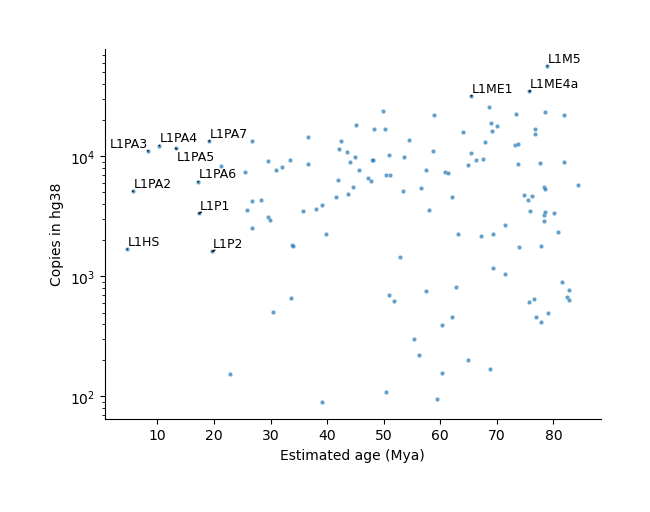

In [64]:
plt.clf()
df = pd.DataFrame({"copies": L1_freq, "age": L1_age}).sort_values(by="age")

g = sns.scatterplot(data=df, x="age", y="copies", alpha=0.7, s=10)
sns.despine()

g.set(xlabel="Estimated age (Mya)", ylabel="Copies in hg38", yscale="log")

# annotate the plots
texts = []
for k, v in L1_freq.items():
    if (L1_age[k] < 20) or (L1_freq[k] > 30000):
        # move above with adjustText
        # make arrows longer
        texts.append(plt.text(L1_age[k], L1_freq[k], k, fontsize=9))

at.adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black"))
# clear

## Plot distribution of *youngest* L1 subfamilies in the human genome

In [5]:
def read_rmsk_L1(rmsk_outfile: str, min_repend: int = 5900):
    "Parse RepeatMasker output file and return a DataFrame of L1s intact 3' ends."

    # parse
    rmsk = read_rmsk(rmsk_outfile)

    # keep L1s in these 6 families with intact 3' ends
    rep_names = ["L1HS", "L1PA2", "L1PA3", "L1PA4", "L1PA5", "L1PA6", "L1PA7"]
    rmsk = rmsk.loc[
        (rmsk["repName"].isin(rep_names)) & (rmsk["repEnd"] > min_repend), :
    ]

    return rmsk


rmsk = read_rmsk_L1(
    "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.out.gz"
)
L1_age = rmsk[["repName", "age"]].set_index("repName").to_dict()["age"]
L1_freq = rmsk["repName"].value_counts().to_dict()

In [ ]:
# remove axis ticks
plt.rcParams.update({"font.size": 20, "ytick.left": False})
pd.Series(L1_freq)[
    ["L1HS", "L1PA2", "L1PA3", "L1PA4", "L1PA5", "L1PA6", "L1PA7"]
].plot.barh(width=0.9).invert_xaxis()
sns.despine(left=True, bottom=True)

# set xlabel
plt.xlabel("Copies in GRCh38")

# convert x axis to scientific notation
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

# save as svg
plt.savefig("L1_freq.svg", bbox_inches="tight")

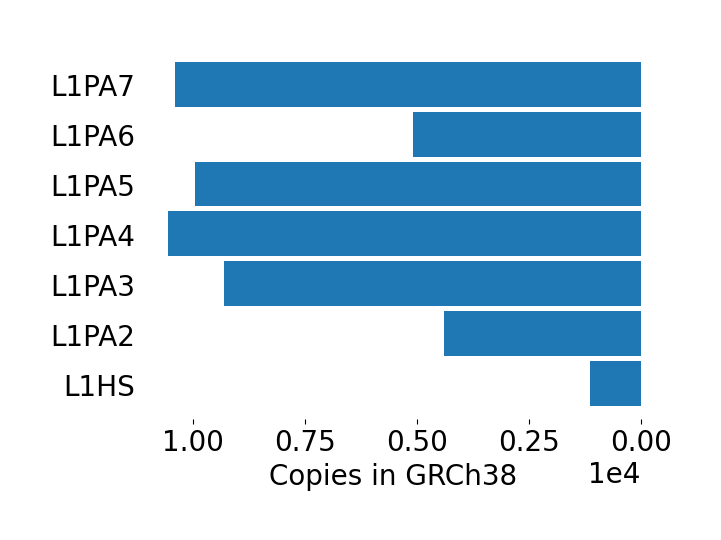

In [8]:
# remove axis ticks
plt.rcParams.update({"font.size": 20, "ytick.left": False})
pd.Series(L1_freq)[
    ["L1HS", "L1PA2", "L1PA3", "L1PA4", "L1PA5", "L1PA6", "L1PA7"]
].plot.barh(width=0.9).invert_xaxis()
sns.despine(left=True, bottom=True)

# set xlabel
plt.xlabel("Copies in GRCh38")

# convert x axis to scientific notation
plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

# save as svg
plt.savefig("L1_freq.svg", bbox_inches="tight")

## Perform Multiple Sequence Alignment (MSA) of youngest L1 subfamilies

In [ ]:
# define L1_3end DFAM accessions
dfam_L1 = [
    "DF0000225",
    "DF0000339",
    "DF0000340",
    "DF0000341",
    "DF0000342",
    "DF0000343",
    "DF0000344",
]

In [ ]:
# retrieve names and consensus sequences using DFAM API
records = []
for acc in dfam_L1:
    url = "https://dfam.org/api/families/" + acc
    data = requests.get(url).json()
    name = data["name"].replace("_3end", "")
    ncopies = L1_freq[name]
    fa = SeqRecord(
        Seq(data["consensus_sequence"]), id="", description=f"{name} ({ncopies} copies)"
    )
    records.append(fa)

# reverse order of records
records = records[::-1]

# fa = SeqRecord(Seq("TGGGAGATATACCTAATGCTAGATGACACA"), id="L1_capture_probe")
# records.append(fa)

# fa = SeqRecord(Seq("TAACTAACCTGCACAATGTGCAC"), id="L1_PCR_primer")
# records.append(fa)

In [ ]:
# pass records to ClustalOmega
with NamedTemporaryFile(mode="w") as tmp_fa:
    SeqIO.write(records, tmp_fa.name, "fasta")
    with NamedTemporaryFile(mode="w") as tmp_aln:
        clustalo_cline = ClustalOmegaCommandline(
            infile=tmp_fa.name, outfile=tmp_aln.name, force=True
        )
        clustalo_cline()

        # read alignment and visualize
        aln = AlignIO.read(tmp_aln.name, "fasta")

In [ ]:
mv = MsaViz(aln, color_scheme="Identity", start=760, label_type="description")
fig = mv.plotfig()

In [ ]:
mv.savefig("L1_msa.svg")